# MODELOS PARA DADOS DE CONTAGEM

MBA DATA SCIENCE & ANALYTICS USP/ESALQ

UNIVERSIDADE DE SÃO PAULO

Prof. Dr. Luiz Paulo Fávero

In [2]:
# Instalação dos pacotes.

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [47]:
# Importação dos pacotes.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp, factorial 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
from scipy.interpolate import interp1d
from statstests.tests import overdisp
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## A DISTRIBUIÇÃO POISSON

In [4]:
#Estabelecendo uma função da distribuição Poisson para determinados valores de lambda.
def poisson_lambda(lmbda,m):
    return (exp(-lmbda) * lmbda ** m) / factorial(m)

In [5]:
# Plotagem da função definida para diferentes valores de lambda.

m = np.arange(0,21)

lmbda_1 = []
lmbda_2 = []
lmbda_4 = []

for item in m:
    # Estabelecendo a distribuição com lambda = 1
    lmbda_1.append(poisson_lambda(1,item))
    # Estabelecendo a distribuição com lambda = 2
    lmbda_2.append(poisson_lambda(2,item))
    # Estabelecendo a distribuição com lambda = 4
    lmbda_4.append(poisson_lambda(4,item))

# Criando um dataframe com m variando de 0 a 20 e diferentes valores de lambda
df_lambda = pd.DataFrame({'m':m, 'lambda_1':lmbda_1, 'lambda_2':lmbda_2, 'lambda_4':lmbda_4})
df_lambda

,m,lambda_1,lambda_2,lambda_4
0,0,3.678794e-01,1.353353e-01,1.831564e-02
1,1,3.678794e-01,2.706706e-01,7.326256e-02
2,2,1.839397e-01,2.706706e-01,1.465251e-01
3,3,6.131324e-02,1.804470e-01,1.953668e-01
4,4,1.532831e-02,9.022352e-02,1.953668e-01
5,5,3.065662e-03,3.608941e-02,1.562935e-01
6,6,5.109437e-04,1.202980e-02,1.041956e-01
7,7,7.299195e-05,3.437087e-03,5.954036e-02
8,8,9.123994e-06,8.592716e-04,2.977018e-02
9,9,1.013777e-06,1.909493e-04,1.323119e-02


In [7]:
def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

In [8]:
x_new, lambda_1 = smooth_line_plot(df_lambda.m, df_lambda.lambda_1)
x_new, lambda_2 = smooth_line_plot(df_lambda.m, df_lambda.lambda_2)
x_new, lambda_4 = smooth_line_plot(df_lambda.m, df_lambda.lambda_4)

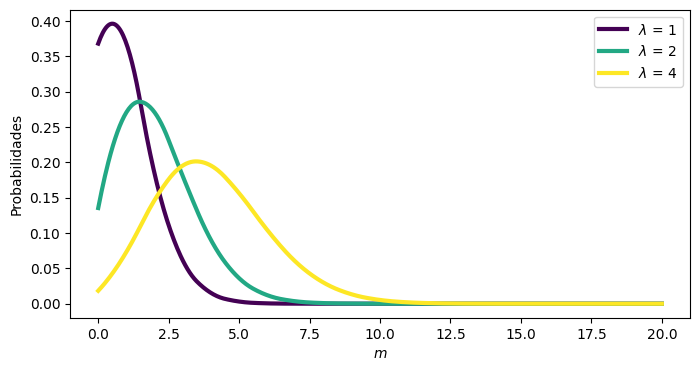

In [13]:
plt.figure(figsize=(8,4))
plt.plot(x_new, lambda_1, linewidth=3, color='#440154FF')
plt.plot(x_new, lambda_2, linewidth=3, color='#22A884FF')
plt.plot(x_new, lambda_4, linewidth=3, color='#FDE725FF')
plt.xlabel('m', fontsize=10, style='italic')
plt.ylabel('Probabilidades', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend([r'$\lambda$ = 1',r'$\lambda$ = 2',r'$\lambda$ = 4'], fontsize=10)
plt.show()

## REGRESSÃO PARA DADOS DE CONTAGEM

In [15]:
# Carregamento da base de dados.
url = 'https://github.com/filipecarbonera/MBA_USP_Data_Science_Analytics/raw/refs/heads/main/Modelos%20para%20Dados%20de%20Contagem/corruption.csv'

df_corruption = pd.read_csv(url, delimiter=',')
df_corruption.head()

# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

,country,code,violations,staff,post,corruption
0,Angola,AGO,50,9,no,1.047506
1,Angola,AGO,1,9,yes,1.047506
2,Albania,ALB,17,3,no,0.921079
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468


In [16]:
# Características das variáveis do dataset.
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [17]:
# Estatísticas univariadas.
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [19]:
# Tabela de frequências da variável dependente 'violations'.

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)
table.head()

,contagem,%
violations,,
0,156,52.35
1,35,11.74
2,16,5.37
3,17,5.70
4,5,1.68


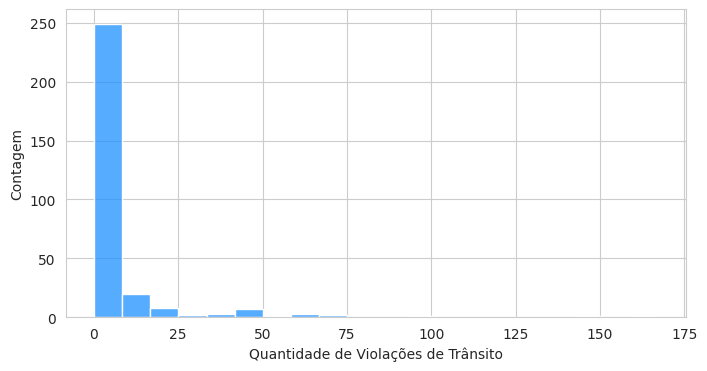

In [22]:
# Histograma da variável dependente 'violations'.

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_corruption, x='violations', bins=20, color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=10)
    plt.ylabel('Contagem', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


In [23]:
# Diagnóstico preliminar para observação de eventual igualdade entre a média e a variância da variável dependente 'violations'.
pd.DataFrame({'Média':[df_corruption.violations.mean()], 'Variância':[df_corruption.violations.var()]})

,Média,Variância
0,6.496644,331.617834


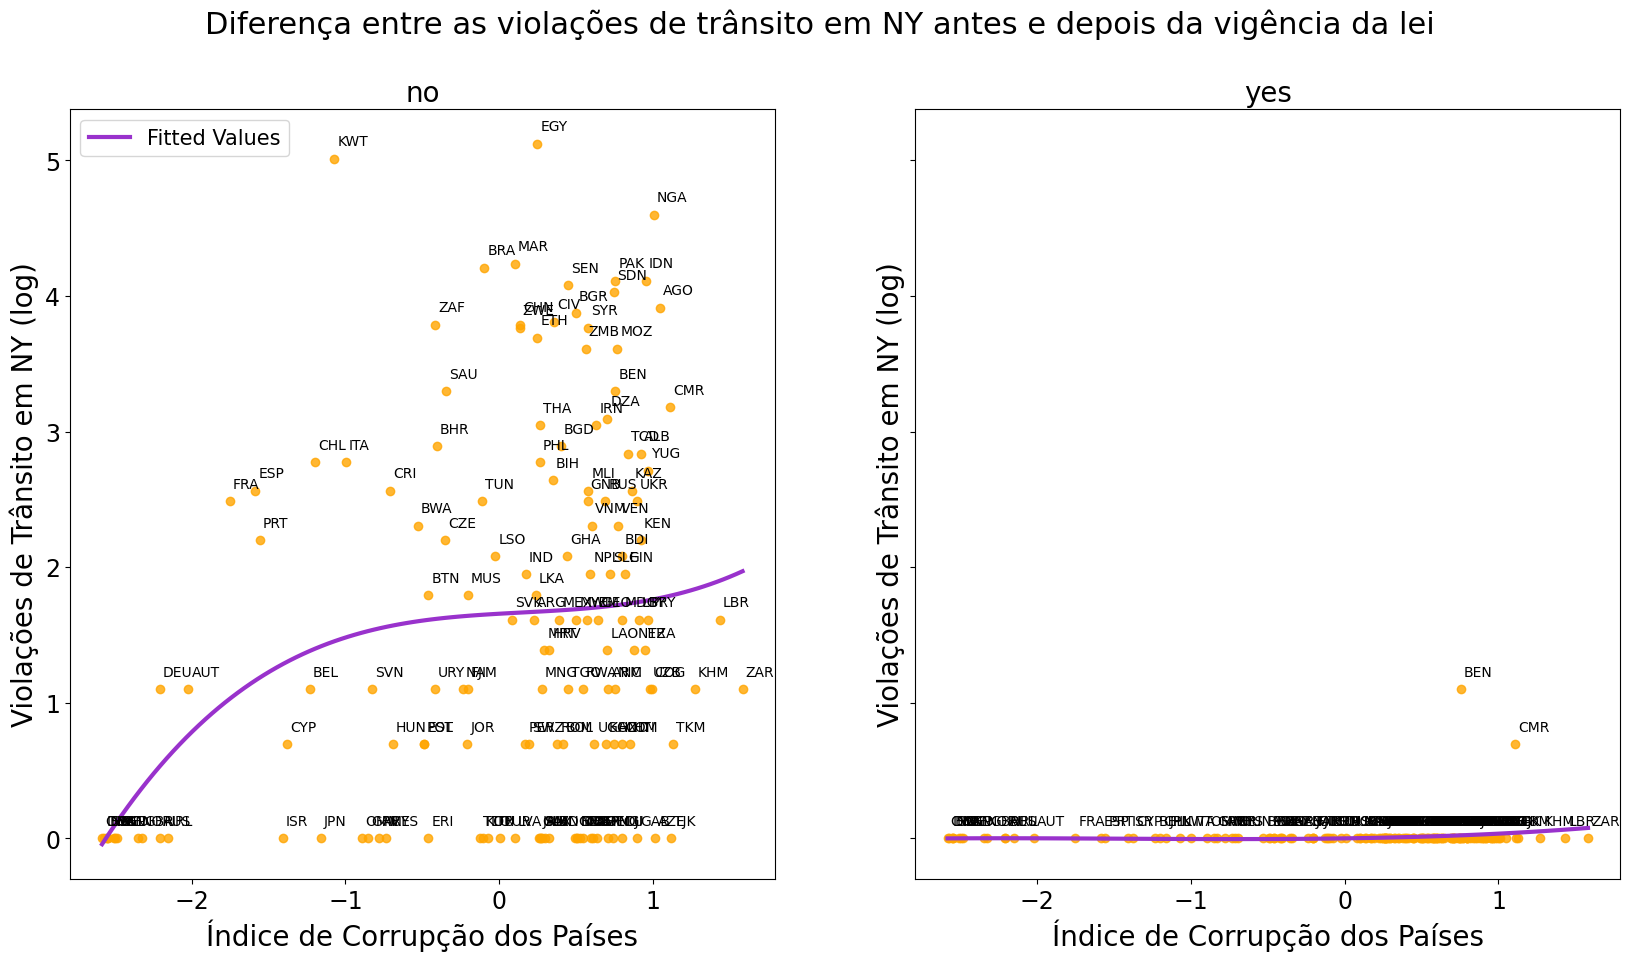

In [24]:
# Comportamento das variáveis 'corruption' e 'violations' antes e depois do início da vigência da lei.

fig, axs = plt.subplots(ncols=2, figsize=(20,10), sharey=True)

fig.suptitle('Diferença entre as violações de trânsito em NY antes e depois da vigência da lei',
             fontsize=22)

post = ['no', 'yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations'] == np.inf, 'violations'] = 0
    df.loc[df['violations'] == -np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',
                order=3, ax=axs[i], ci=False,
                line_kws={'color':'darkorchid', 'linewidth': 3,
                          'label':'Fitted Values'},
                scatter_kws={'color':'orange'})
    axs[i].set_title(v, fontsize=20)
    axs[i].set_ylabel("Violações de Trânsito em NY (log)", fontsize=20)
    axs[i].set_xlabel("Índice de Corrupção dos Países", fontsize=20)
    label_point(df.corruption, df.violations, df.code, axs[i])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=17)
    
axs[0].legend(loc='upper left', fontsize=15)

plt.show()

In [25]:
# Estimação do modelo Poisson.

# O argumento 'family=sm.families.Poisson()' da função 'smf.glm' define a estimação de um modelo Poisson.
modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption, family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson'
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Wed, 13 Nov 2024   Deviance:                       3644.0
Time:                        21:13:42   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

Todas as variáveis preditoras se mostraram estatisticamente diferentes de zero, considerando-se um nível de significância de 5%, ceteris paribus. Porém, já se pode afirmar que a estimação Poisson é a mais adequada?

## TESTE DE SUPERDISPERSÃO DE CAMERON E TRIVEDI (1990)

CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

- 1º Passo: estimar um modelo Poisson;

- 2º Passo: criar uma nova variável (Y*) utilizando os fitted values do modelo Poisson estimado anteriormente;

- 3º Passo: estimar um modelo auxiliar OLS, com a variável Y* como variável dependente, os fitted values do modelo Poisson como única variável preditora e sem o intercepto;

- 4º Passo: Observar a significância do parâmetro beta.

In [28]:
# Adicionando os fitted values do modelo Poisson ('lambda_poisson') ao dataframe.
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson
0,Angola,AGO,50,9,no,1.047506,15.919915
1,Angola,AGO,1,9,yes,1.047506,0.216711
2,Albania,ALB,17,3,no,0.921079,13.371720
3,Albania,ALB,0,3,yes,0.921079,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915


In [31]:
# Criando a nova variável Y* ('ystar').
df_corruption['ystar'] = (((df_corruption['violations']-df_corruption['lambda_poisson'])**2)-
    df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson,ystar
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915


In [32]:
# Estimando o modelo auxiliar OLS, sem o intercepto.
modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson', df_corruption).fit()

# Parâmetros do 'modelo_auxiliar'.
modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Wed, 13 Nov 2024   Prob (F-statistic):                     0.00625
Time:                        21:17:55   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     2.6525      0.963      2.754      0.006       0.757       4.548
==============================================================================
Omnibus:                      607.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446004.649
Skew:                          13.265   Prob(JB):                         0.00
Kurtosis:                     190.659   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Caso o p-value do parâmetro de lambda_poisson seja maior que 0.05, verifica-se a existência de equidispersão nos dados. Caso contrário, diagnostica-se a existência de superdispersão nos dados, fato que favorecerá a estimação de um modelo binomial negativo, como ocorre nesse caso.


## Função 'overdisp'

Uma abordagem mais direta para a detecção da superdispersão pelo Teste de Cameron e Trivedi (1990) é por meio da utilização da função 'overdisp' do pacote 'statstests.tests'.

Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'

Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos

https://stats-tests.github.io/statstests/

In [34]:
# Elaboração direta do teste de superdispersão.
overdisp(modelo_poisson, df_corruption)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-11-13 21:20 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

In [35]:
# Qual seria a quantidade média esperada de violações de trânsito para o mesmo país, porém agora considerando a vigência da lei?
modelo_poisson.predict(pd.DataFrame({'staff':[23], 'post':['yes'], 'corruption':[0.5]}))

0    0.244112
dtype: float64

## A DISTRIBUIÇÃO BINOMIAL NEGATIVA

Estabelecendo uma função da distribuição binomial negativa para determinados valores de theta e delta.

- theta: parâmetro de forma da distribuição Poisson-Gama (binomial negativa).

- delta: parâmetro de taxa de decaimento da distribuição Poisson-Gama.

In [36]:
def bneg(theta, delta, m):
    return ((delta ** theta) * (m ** (theta - 1)) * (exp(-m * delta))) / factorial(theta - 1)

In [38]:
# Plotagem das funções estabelecidas para diferentes valores de theta e delta.

m = np.arange(1,21)

bneg_theta2_delta2 = []
bneg_theta3_delta1 = []
bneg_theta3_delta05 = []

for item in m:
    # Estabelecendo a distribuição binomial negativa com theta=2 e delta=2
    bneg_theta2_delta2.append(bneg(2,2,item))
    # Estabelecendo a distribuição binomial negativa com theta=3 e delta=1
    bneg_theta3_delta1.append(bneg(3,1,item))
    # Estabelecendo a distribuição binomial negativa com theta=3 e delta=0.5
    bneg_theta3_delta05.append(bneg(3,0.5,item))
   
# Criando um dataframe com m variando de 1 a 20 e diferentes valores de
#theta e delta
df_bneg = pd.DataFrame({'m':m, 'bneg_theta2_delta2':bneg_theta2_delta2,
    'bneg_theta3_delta1':bneg_theta3_delta1, 'bneg_theta3_delta05':bneg_theta3_delta05})

df_bneg.head()

,m,bneg_theta2_delta2,bneg_theta3_delta1,bneg_theta3_delta05
0,1,0.541341,0.183940,0.037908
1,2,0.146525,0.270671,0.091970
2,3,0.029745,0.224042,0.125511
3,4,0.005367,0.146525,0.135335
4,5,0.000908,0.084224,0.128258


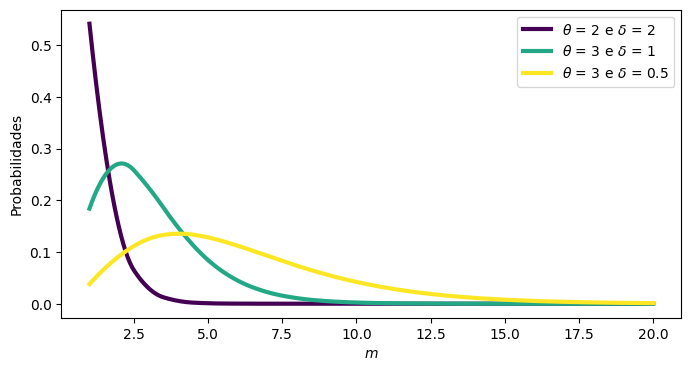

In [45]:
# Plotagem propriamente dita.

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, bneg_theta2_delta2 = smooth_line_plot(df_bneg.m, df_bneg.bneg_theta2_delta2)
x_new, bneg_theta3_delta1 = smooth_line_plot(df_bneg.m, df_bneg.bneg_theta3_delta1)
x_new, bneg_theta3_delta05 = smooth_line_plot(df_bneg.m, df_bneg.bneg_theta3_delta05)

plt.figure(figsize=(8,4))
plt.plot(x_new,bneg_theta2_delta2, linewidth=3, color='#440154FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=3, color='#22A884FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=3, color='#FDE725FF')
plt.xlabel('m', fontsize=10, style='italic')
plt.ylabel('Probabilidades', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend([r'$\theta$ = 2 e $\delta$ = 2',
            r'$\theta$ = 3 e $\delta$ = 1',
            r'$\theta$ = 3 e $\delta$ = 0.5'],
           fontsize=10)
plt.show()

## Estimação do modelo binomial negativo do tipo NB2

O argumento 'family=sm.families.NegativeBinomial(alpha=2.0963)' da função 'smf.glm' define a estimação de um modelo binomial negativo do tipo NB2 com valor de 'fi' ('alpha' no Python) igual a 2.0963 (valor proveniente da estimação realizada por meio do Solver do Excel). Lembramos que 'fi' é o inverso do parâmetro de forma 'theta' da distribuição Poisson-Gama.

In [46]:
modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption, family=sm.families.NegativeBinomial(alpha=2.0963)).fit()

# Parâmetros do 'modelo_bneg'.
modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Wed, 13 Nov 2024   Deviance:                       239.13
Time:                        21:26:27   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      0.000       1.630       2.264
post[T.yes]    -4.2746      0.266    -16.071      0.000      -4.796      -3.753
staff           0.0400      0.009      4.497      0.000       0.023       0.057
corruption      0.4527      0.115      3.950      0.000       0.228       0.677
===============================================================================
"""

In [48]:
# Construção de uma função para a definição do 'fi' ótimo (argumento 'alpha') que gera a maximização do valor de Log-Likelihood.

n_samples = 10000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)

for i, alpha in tqdm(enumerate(alphas), total=n_samples, desc='Estimating'):
    try:
        model = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf

fi_ótimo = alphas[np.nanargmax(llf)].round(4)
fi_ótimo


Estimating: 100%|██████████| 10000/10000 [03:00<00:00, 55.37it/s]


2.0962

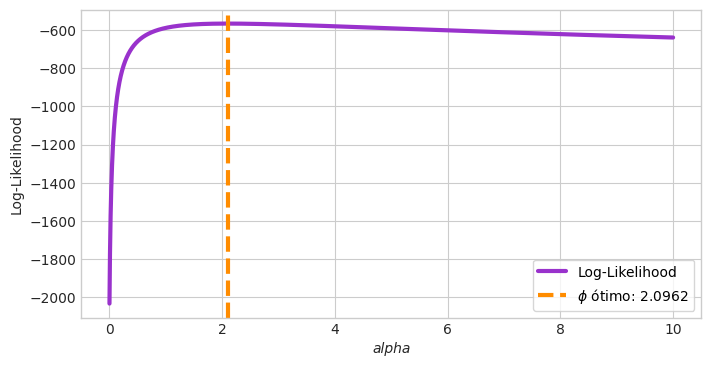

In [49]:
# Plotagem dos resultados (Log-likelihood x fi).

plt.figure(figsize=(8, 4))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(alphas, llf, label='Log-Likelihood', color='darkorchid', linewidth = 3)
    plt.axvline(x=fi_ótimo, color='darkorange', linewidth = 3, linestyle='dashed',
            label=f'$\phi$ ótimo: {round(fi_ótimo, 4)}')
plt.xlabel('alpha', fontsize=10, style='italic')
plt.ylabel('Log-Likelihood', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.show()

In [50]:
# Reestimação do modelo binomial negativo com o parâmetro 'fi_ótimo'.

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption, family=sm.families.NegativeBinomial(alpha=fi_ótimo)).fit()

# Parâmetros do 'modelo_bneg'
modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Wed, 13 Nov 2024   Deviance:                       239.14
Time:                        21:31:51   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      0.000       1.630       2.264
post[T.yes]    -4.2746      0.266    -16.071      0.000      -4.796      -3.753
staff           0.0400      0.009      4.497      0.000       0.023       0.057
corruption      0.4527      0.115      3.950      0.000       0.228       0.677
===============================================================================
"""

In [51]:
# Comparando os modelos Poisson e binomial negativo.

summary_col([modelo_poisson, modelo_bneg], model_names=["Poisson","BNeg"], stars=True,
            info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)),
                         'Log-lik':lambda x: "{:.2f}".format(x.llf)})


,Poisson,BNeg
Intercept,2.2127***,1.9469***
,(0.0311),(0.1616)
post[T.yes],-4.2968***,-4.2746***
,(0.1974),(0.2660)
staff,0.0219***,0.0400***
,(0.0012),(0.0089)
corruption,0.3418***,0.4527***
,(0.0275),(0.1146)
Log-lik,-2071.79,-567.40
N,298,298


In [52]:
# Definição da função para realização do teste de razão de verossimilhança.

# Definição da função 'lrtest'.
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [53]:
# Teste de de razão de verossimilhança para comparar as estimações dos 'modelo_poisson' e 'modelo_bneg'.
lrtest([modelo_poisson, modelo_bneg])

# Gráfico para a comparação dos LogLiks dos modelos Poisson e binomial negativo.

# Definição do dataframe com os modelos e respectivos LogLiks.
df_llf = pd.DataFrame({'modelo':['Poisson','BNeg'], 'loglik':[modelo_poisson.llf, modelo_bneg.llf]})
df_llf

Likelihood Ratio Test:
-2.(LL0-LLm): 3008.79
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


,modelo,loglik
0,Poisson,-2071.793753
1,BNeg,-567.401172


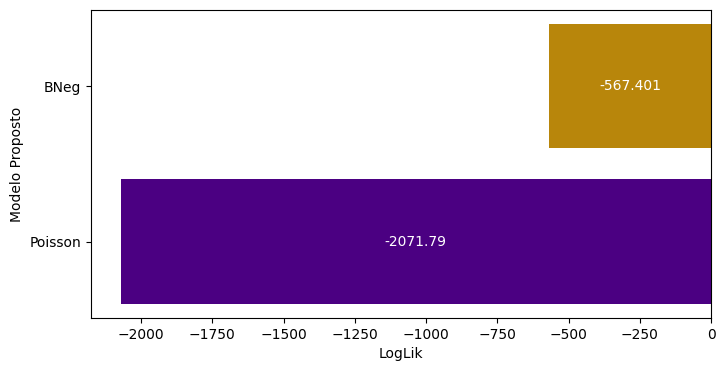

In [55]:
# Plotagem propriamente dita.
fig, ax = plt.subplots(figsize=(8,4))

c = ['indigo', 'darkgoldenrod']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=10)
ax.set_ylabel("Modelo Proposto", fontsize=10)
ax.set_xlabel("LogLik", fontsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
plt.show()

## COMPARAÇÕES ENTRE AS PREVISÕES

Qual seria a quantidade média esperada de violações de trânsito para um país cujo corpo diplomático seja composto por 23 membros, considerando o período anterior à vigência da lei e cujo índice de corrupção seja igual 0.5?

In [64]:
# Modelo Poisson:
print('Modelo Poisson\n', modelo_poisson.predict(pd.DataFrame({'staff':[23], 'post':['no'], 'corruption':[0.5]})),'\n')

# Modelo binomial negativo:
print('Modelo binomial negativo\n', modelo_bneg.predict(pd.DataFrame({'staff':[23], 'post':['no'], 'corruption':[0.5]})))

Modelo Poisson
 0    17.93284
dtype: float64 

Modelo binomial negativo
 0    22.057246
dtype: float64


In [68]:
# Adicionando os fitted values dos modelos estimados até o momento, para fins de comparação.

# Modelo Poisson:
df_corruption['fitted_poisson'] = modelo_poisson.fittedvalues

# Modelo binomial negativo:
df_corruption['fitted_bneg'] = modelo_bneg.fittedvalues

# Visualização do dataframe com os fitted values do modelos estimados.
df_corruption[['country','code','violations','fitted_poisson','fitted_bneg']].head()

,country,code,violations,fitted_poisson,fitted_bneg
0,Angola,AGO,50,15.919915,16.138592
1,Angola,AGO,1,0.216711,0.224603
2,Albania,ALB,17,13.371720,11.987630
3,Albania,ALB,0,0.182023,0.166834
4,United Arab Emirates,ARE,0,7.477915,5.551770


<function matplotlib.pyplot.show(close=None, block=None)>

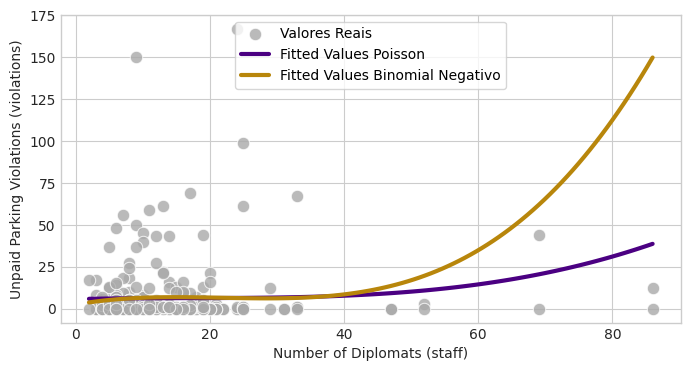

In [72]:
# Fitted values dos modelos Poisson e binomial negativo, considerando, para fins didáticos, apenas a variável preditora 'staff'.

plt.figure(figsize=(8,4))
with plt.style.context('seaborn-v0_8-whitegrid'):
    sns.scatterplot(x='staff', y='violations', data=df_corruption, color='darkgrey',
                s=80, label='Valores Reais', alpha=0.8)
    sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3, ci=False,
            scatter=False, color='indigo',
            label='Fitted Values Poisson',
            line_kws={'linewidth': 3})
    sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3, ci=False,
            scatter = False, color='darkgoldenrod',
            label='Fitted Values Binomial Negativo',
            line_kws={'linewidth': 3})
plt.xlabel('Number of Diplomats (staff)', fontsize=10)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center', fontsize=10)
plt.show

## ESTIMAÇÕES MUITO PRÓXIMAS PARA POISSON E BNEG SEM SUPERDISPERSÃO!

Para fins didáticos, vamos gerar novo dataframe 'df_corruption2', com quantidades de violações de trânsito iguais, no máximo, a 3. Este procedimento poderá, eventualmente, eliminar o fenômeno da superdispersão nos dados da variável dependente e, consequentemente, tornar as estimações dos modelos POISSON e BINOMIAL NEGATIVO praticamente iguais.

In [80]:
# Gerando novo dataframe ('df_corruption2') com seleção das variáveis originais.
df_corruption2 = df_corruption.iloc[:, 0:6]
df_corruption2.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [75]:
# Seleção das observações com 'violations' menores ou iguais a 3
df_corruption2 = df_corruption2[df_corruption2['violations'] <= 3]
df_corruption2.head()

,country,code,violations,staff,post,corruption
1,Angola,AGO,1,9,yes,1.047506
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468
5,United Arab Emirates,ARE,0,3,yes,-0.779468
7,Argentina,ARG,0,19,yes,0.223567


In [77]:
# Características do dataframe (224 observações)
df_corruption2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 1 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     224 non-null    object 
 1   code        224 non-null    object 
 2   violations  224 non-null    int64  
 3   staff       224 non-null    int64  
 4   post        224 non-null    object 
 5   corruption  224 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 12.2+ KB


In [79]:
# Estatísticas univariadas (note que o valor máximo de ocorrências na variável 'violations' agora é 3).
df_corruption2.describe()

,violations,staff,corruption
count,224.000000,224.000000,224.000000
mean,0.526786,11.415179,-0.085940
std,0.922658,10.509101,1.085816
min,0.000000,2.000000,-2.582988
25%,0.000000,5.000000,-0.499298
50%,0.000000,9.000000,0.279324
75%,1.000000,14.000000,0.702910
max,3.000000,86.000000,1.582807


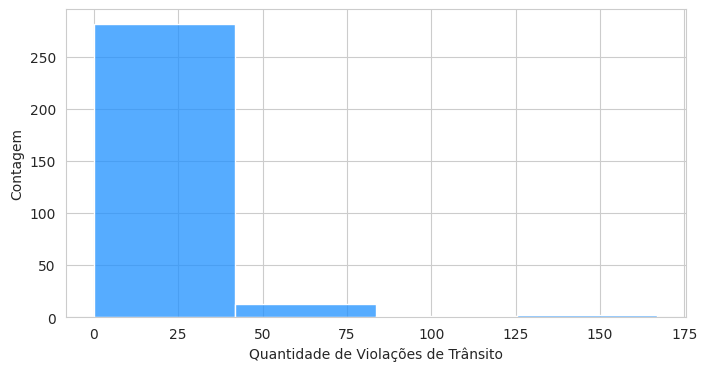

In [83]:
# Histograma da variável dependente 'violations' no dataframe 'df_corruption2'.

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_corruption2, x='violations', bins=4, color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=10)
    plt.ylabel('Contagem', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

Diagnóstico preliminar para observação de eventual igualdade entre a média e a variância da variável dependente 'violations' no dataframe 'df_corruption2'.

In [84]:
pd.DataFrame({'Média':[df_corruption2['violations'].mean()], 'Variância':[df_corruption2['violations'].var()]})

,Média,Variância
0,6.496644,331.617834


In [85]:
# Estimação do 'modelo_poisson2'.
modelo_poisson2 = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption2, family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson2'.
modelo_poisson2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Wed, 13 Nov 2024   Deviance:                       3644.0
Time:                        21:45:22   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

In [86]:
# Teste de superdispersão no dataset 'corruption2'.
overdisp(modelo_poisson2, df_corruption2)

#  Estimação do modelo binomial negativo ('modelo_bneg2') no dataframe 'df_corruption2'.
n_samples = 1000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)

for i, alpha in tqdm(enumerate(alphas), total=n_samples, desc='Estimating'):
    try:
        model = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption2, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf

fi_ótimo2 = alphas[np.nanargmax(llf)].round(4)
fi_ótimo2

# Estimação propriamente dita do 'modelo_bneg2'.
modelo_bneg2 = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption2, family=sm.families.NegativeBinomial(alpha=fi_ótimo2)).fit()

# Parâmetros do 'modelo_bneg2'.
modelo_bneg2.summary()

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-11-13 21:46 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

Estimating: 100%|██████████| 1000/1000 [00:22<00:00, 43.68it/s]


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Wed, 13 Nov 2024   Deviance:                       239.46
Time:                        21:47:04   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6720
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9470      0.161     12.061      0.000       1.631       2.263
post[T.yes]    -4.2747      0.266    -16.078      0.000      -4.796      -3.754
staff           0.0400      0.009      4.500      0.000       0.023       0.057
corruption      0.4526      0.115      3.953      0.000       0.228       0.677
===============================================================================
"""

In [88]:
# Comparando os parâmetros e os valores de LogLiks dos 'modelo_poisson2' e 'modelo_bneg2'.
summary_col([modelo_poisson2, modelo_bneg2], 
            model_names=["Poisson","BNeg"], stars=True,
            info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)), 'Log-lik':lambda x: "{:.2f}".format(x.llf)})


,Poisson,BNeg
Intercept,2.2127***,1.9470***
,(0.0311),(0.1614)
post[T.yes],-4.2968***,-4.2747***
,(0.1974),(0.2659)
staff,0.0219***,0.0400***
,(0.0012),(0.0089)
corruption,0.3418***,0.4526***
,(0.0275),(0.1145)
Log-lik,-2071.79,-567.40
N,298,298


In [90]:
# Teste de de razão de verossimilhança para comparar as estimações dos 'modelo_poisson2' e 'modelo_bneg2'.
lrtest([modelo_poisson2, modelo_bneg2])

# Quando não há superdispersão, não existem diferenças significantes entre os modelos Poisson e binomial negativo!

Likelihood Ratio Test:
-2.(LL0-LLm): 3008.78
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


# A DISTRIBUIÇÃO ZERO-INFLATED POISSON (ZIP) - PARTE CONCEITUAL